In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GMM # today's workhorse!

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Our data today comes from a proper motion study of the classic open cluster M67 by [Yadav et al. (2008)](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/A%2bA/484/609)

In [19]:
# the data file is in the data/ directory, as per usual!
file = './data/J_A+A_484_609_catalog.dat'

# OPEN the data file and look at the columns, give them names since Pandas won't 
# easily understand the file conventions used by Vizier
colnames = ['Seq', 'RADEdeg','Xpos','Ypos','Bmag','e_Bmag','Vmag','e_Vmag','Icmag','e_Icmag','pmRA','e_pmRA','pmDE',
            'e_pmDE','Pmb','HRV','e']

df = pd.read_table(file, delimiter='|', skiprows=5, header=None,
                  names=colnames)


#df

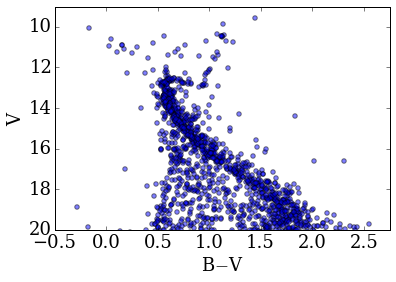

In [119]:
'''
Make a scatter plot of the Color vs Magnitude Diagram (CMD) using the (B-V, V) space

set the x-axis limits to be -0.5 to 2.75
set the y-axis limits to be 20 to 9

Use alpha=0.5 to see over densities easier
'''

plt.scatter(df['Bmag']-df['Vmag'], df['Vmag'],alpha=0.5)
plt.xlim(-0.5,2.75)
plt.ylim(20,9)
plt.xlabel('B$-$V')
plt.ylabel('V')

(-20, 20)

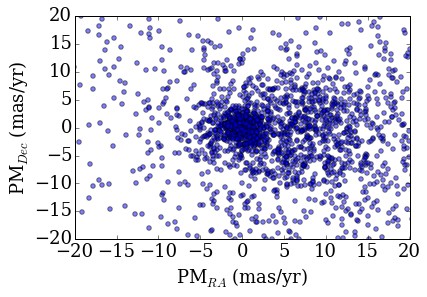

In [118]:
''' 
Make a scatter plot of the proper motions (RA, Dec)

Set the X- and Y-axis limits to be +/- 20

Make the figure square for easier reading

Use alpha=0.5 to see over densities easier
'''

plt.scatter(df['pmRA'], df['pmDE'],alpha=0.5)
plt.xlabel('PM$_{RA}$ (mas/yr)')
plt.ylabel('PM$_{Dec}$ (mas/yr)')
plt.xlim(-20,20)
plt.ylim(-20,20)

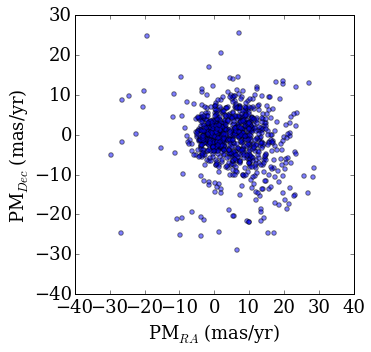

In [116]:
'''
Remake the PM diagram above, but get rid of faint data, 
stars with missing magnitudes, and stars with outliers in the PM
'''
x = np.where((df['Bmag'] < 21) & (df['Vmag'] < 20) & 
            (df['pmRA'] < 30) & (df['pmRA'] > -30) & (df['pmDE'] < 30) & (df['pmDE'] > -30))


# reminder: you have to use the .values method to get just the data out when indexing. Annoying, but easy
plt.figure(figsize=(5,5))
plt.scatter(df['pmRA'].values[x], df['pmDE'].values[x],alpha=0.5)
plt.xlabel('PM$_{RA}$ (mas/yr)')
plt.ylabel('PM$_{Dec}$ (mas/yr)')

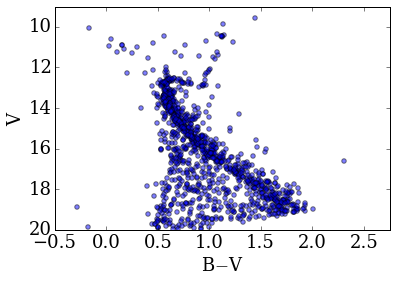

In [115]:
plt.scatter(df['Bmag'].values[x] - df['Vmag'].values[x], df['Vmag'].values[x],alpha=0.5)
plt.xlim(-0.5,2.75)
plt.ylim(20,9)
plt.xlabel("B$-$V")
plt.ylabel('V')

# Gaussian Mixture Model

Let's try to model the Proper Motion Diagram using GMM. We'll use this to classify **cluster** versus **field** stars. These classifications will then be used to clean up the CMD above!

We're going to loosely follow the sklearn [example on GMM](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html), and also a very [useful blog post](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) by Jake VanderPlas that uses GMM

### [GMM Doccumentation ](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM)

In [58]:
'''
We need to feed GMM our 2-dimensional data as 1 array. It should have dimensions (N,K), where K=2 here

Also, use the index we created above to remove bad data.

Here's 1 way to do that...
'''
data = np.array( (df['pmRA'].values[x], df['pmDE'].values[x]) ).T # the .T does a Transpose!
data.shape

# Try it w/ and w/o the .T to see how that works...


array([ 11.96,  -6.43])

### A step-by-step through GMM

In [59]:
''' 
Step 1: Initialize the type of GMM we want

How many models to fit? 
What "type" or shape of Gaussian to use? (can be ‘spherical’, ‘tied’, ‘diag’, ‘full’)

Many other options can be set here, see the GMM doc's!
'''

# PLAY WITH THESE PARAMETERS - I have intentionally made them wrong

Nmodels = 2 # tell it how many Gaussians to fit. we probably only want 2 Gaussians for this problem

ctype = 'full' # what type of Gaussian to fit?
# you can see all 4 examples here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html


gmm_model = GMM(n_components=Nmodels, covariance_type=ctype)

In [60]:
'''
Step 2: Fit the data with the GMM

This is straight forward if your data is shaped correctly. It simply tries to fit the K-dimensional 
data (again, K=2 here) with the specified # of Gaussians.

NOTE: you can fit any number of K dimenions of data, provided the features look like K-dimensional Gaussians
'''

gmm_model.fit(data)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)

In [61]:
'''
Step 3: Make predictions or classifications based on the fit.

Since we're just trying to classify our existing data, we are just going to "predict" based 
on the input data again. 

If we had *new* data we wanted to classify, we could drop it in here instead.
'''

clabel = gmm_model.predict(data)

# there is a "label" (a prediction) for every data point we just fed it
clabel.shape

(1194,)

In [62]:
'''
Step 3b: Look at Probabilities

One of the best parts of GMM is that it produces a probability for every object being a member of
every Gaussian cluster! Thus, you could pick out only targets with very high probabilities.

'''

probs = gmm_model.predict_proba(data)
print(probs.shape) # this has dimensions (N data points, Nmodels)


# Let's look at the 100th star in our dataset.
i = 100

# does it belong to cluster 0 or 1? How certain is it?
print(probs[i,:], clabel[i])

(1194, 2)
[  1.00000000e+00   1.62145401e-35] 0


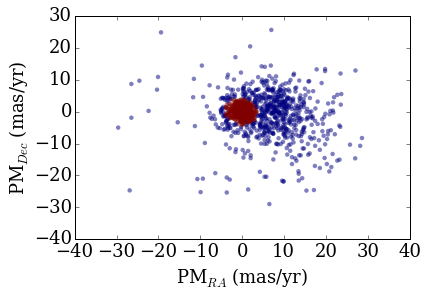

In [67]:
'''
Step 4: View and Use these predictions

We have these labels, but maybe they are meaningless junk... the only way to know is to LOOK at the outputs.

Re-make your plot of the PM diagram, but color datapoints based on the predictions!

be sure to make it square again
also, set the x/y axis limits again, etc.
'''

# here's a freebie. You already have your "data" variable
plt.scatter(data[:,0], data[:,1],
            c=clabel,lw=0,alpha=0.5) # and you can color using the 0's/1's label vector
plt.xlabel('PM$_{RA}$ (mas/yr)')
plt.ylabel('PM$_{Dec}$ (mas/yr)')

If you wanted to plot *contours* for each of the Gaussians, you could follow [this example](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py)

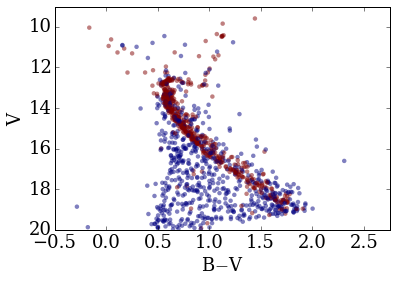

In [65]:
'''
Now, re-plot the CMD for the cluster, but color by the predictions as above.
'''
plt.scatter(df['Bmag'].values[x] - df['Vmag'].values[x], df['Vmag'].values[x],alpha=0.5,c=clabel,lw=0)
plt.xlim(-0.5,2.75)
plt.ylim(20,9)
plt.xlabel("B$-$V")
plt.ylabel('V')


(20, 9)

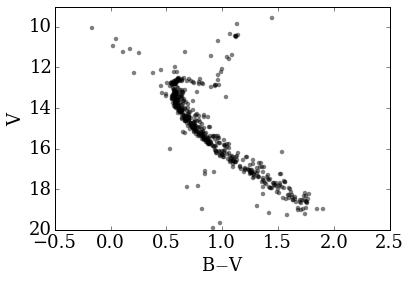

In [108]:
'''
OR - you could just plot the likely cluster members only

NOTE: this may be 1 or 0. It's basically random depending on which cluster it assigned first.
'''
cl = np.where((clabel == 1))

plt.scatter(df['Bmag'].values[x][cl] - df['Vmag'].values[x][cl], df['Vmag'].values[x][cl], alpha=0.5, lw=0, c='k')
plt.xlabel("B$-$V")
plt.ylabel('V')
plt.xlim(-0.5,2.5)
plt.ylim(20,9)

There is so much more to learn about Machine Learning for astronomy. 

I would *highly* suggest flipping through these [videos](https://www.youtube.com/playlist?list=PLzWVyeIO6Cmt1cWrzwF2yqW-9j5TgyQaD) and IPython [notebooks](https://github.com/jakevdp/ESAC-stats-2014) produced by Jake VanderPlas from 2014, which give practical examples of using machine learning in astronomy.

ALSO, be sure to pick up a copy of [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.amazon.com/Statistics-Mining-Machine-Learning-Astronomy/dp/0691151687)

### Bonus plots:

Here are some other really cool plots you could make if you were ambitious...

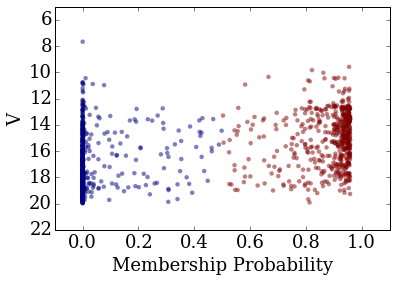

In [103]:
# Probability of membership in cluster versus V-band magnitude
plt.scatter(probs[:,1],df['Vmag'].values[x],alpha=0.5,lw=0,c=clabel)
plt.xlim(-0.1,1.1)
plt.ylim(22,5)
plt.xlabel('Membership Probability')
plt.ylabel("V")


(-0.1, 1.1)

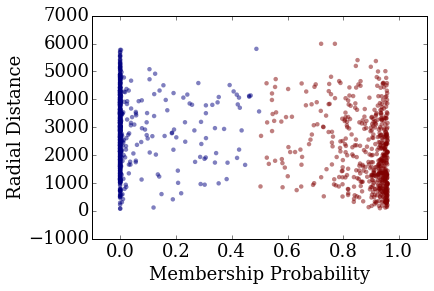

In [120]:
# Probability of membership in cluster versus radial distance from center of the field (using xpos and ypos)
d = np.sqrt((df['Xpos'].values[x] - np.median(df['Xpos']))**2 + (df['Ypos'].values[x] - np.median(df['Ypos']))**2)

plt.scatter(probs[:,1],d,alpha=0.5,lw=0,c=clabel)
plt.xlabel('Membership Probability')
plt.ylabel('Radial Distance')
plt.xlim(-0.1,1.1)

(-0.1, 1.1)

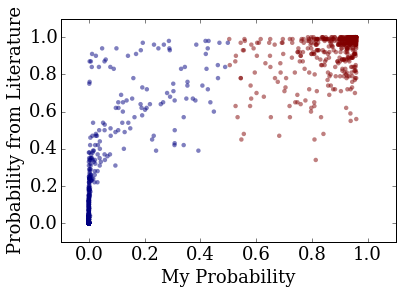

In [106]:
# Comparison of your GMM cluster probabilities with the probabilities computed in the actual 
# scientific research paper, Yadav et al. (2008), using the Pmb column in the data

plt.scatter(probs[:,1],0.01*df['Pmb'].values[x],alpha=0.5,lw=0,c=clabel)
plt.xlabel('My Probability')
plt.ylabel('Probability from Literature')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
